# Heatwave: Risk assessment

## Step 1: Workflow description 

Based on the current climate scenario the occurrence of the heatwave phenomenon should be more frequent in the future in Europe. The main problems connected with heatwave events are the overheating of the urban areas, which lowers the comfort of living or causes health issues[[Integrated Assessment of Urban Overheating Impacts on Human Life](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2022EF002682)], drought, and water scarcity. Nowadays, there are a lot of studies and methodologies on how we can mitigate the influence of these events. This toolbox wants to answer simple questions that are more frequently asked by crisis management local authorities, urban planners, or policymakers. 

 - These questions are:
   1. What are the problematic areas? (most overheated areas)
   2. Who or What is exposed?

This workflow provided multiple steps to achieving the risk map for your selected area.
1. Workflow description
2. Importing of the packages needed for the running of the workflow
3. Creating the directory structure for the saving of the downloaded and created data
4. Setting of CDS API key, for the downloading of the CDS observed air temperature data
5. Look at the Trends of the heat days/nights occurrence change under the climate scenarios
6. Downloading the daily observed air temperature data (12x12km grid) from the CDS 
7. Identify the heat islands (**heat exposed areas**) in your selected area. Based on the observed data from RSLab Landsat8 land surface temperature (30x30m)
8. Identification of the distribution of vulnerable population (**vulnerable population**). Based on the world population data. 
9. Calculation of the heatwave risk map based on the **risk= heat exposed areas x vulnerable areas**
10. Conclusion
11. Calculation of the vegetation characteristics, based on the NDVI values calculated from the Sentinel2 observed data
12. References
13. Authors

## Step 2: Import packages

### Prepare your workspace
:::{admonition} In this notebook we will use the following Python libraries:
:class: hint dropdown
* [zipfile](https://docs.python.org/3/library/zipfile.html) - Working with ZIP archive files.
* [os](https://docs.python.org/3/library/os.html) - Handling the current working directory.
* [rasterio](https://rasterio.readthedocs.io/en/latest/) - NetCDF and raster processing.
* [pathlib](https://docs.python.org/3/library/pathlib.html) - File system paths.
* [cdsapi](https://cds.climate.copernicus.eu/api-how-to) - API for downloading climate data.
* [numpy](https://numpy.org/doc/stable/) - 2-3D array data handling.
* [xarray](https://docs.xarray.dev/en/stable/) - 2-3D array data handling.
* [cartopy](https://scitools.org.uk/cartopy/docs/latest/) - NetCDF data projection.
* [matplotlib](https://matplotlib.org/stable/) - Data plotting.
* [geopandas](https://geopandas.org/en/stable/) - Geospatial data handling.
* [plotly](https://plotly.com/) - Creating interactive plots.
* [sklearn](https://scikit-learn.org/stable/modules/linear_model.html#linear-regression) - Linear regression model.
* [ipyleaflet](https://ipyleaflet.readthedocs.io/en/stable/) - Interactive maps in Jupyter notebooks.
* [ipywidgets](https://ipywidgets.readthedocs.io/en/stable/) - Creating interactive HTML widgets.
* [leafmap](https://leafmap.org/) - Geospatial data visualization and analysis.
* [localtileserver](https://localtileserver.readthedocs.io/en/latest/) - Creating tile layers for maps.
* [datetime](https://docs.python.org/3/library/datetime.html) - Handling dates and times.
* [json](https://docs.python.org/3/library/json.html) - Handling JSON data.
* [random](https://docs.python.org/3/library/random.html) - Generating random numbers.
* [requests](https://docs.python-requests.org/en/latest/) - Making HTTP requests.
* [rasterstats](https://pythonhosted.org/rasterstats/) - Zonal statistics for raster data.
* [plotly.express](https://plotly.com/python/plotly-express/) - Creating interactive plots.
* [folium](https://python-visualization.github.io/folium/) - Creating interactive maps.
* [branca](https://python-visualization.github.io/branca/) - Color maps for folium maps.
* [rasterio.transform](https://rasterio.readthedocs.io/en/latest/api/rasterio.transform.html) - Coordinate transformations for raster data.


In [1]:
import zipfile  # working with the zip folders
import os  # handling the current working directory
import rasterio  # netcdf and raster processing
from pathlib import Path  # file system paths
import cdsapi  # API downloading
import numpy as np  # 2-3D array data handling
import xarray as xr  # 2-3D array data handling
import cartopy.crs as ccrs  # netcdf data projection
import cartopy.feature as cf  # netcdf data projection
import matplotlib as mpl  # data plot
import matplotlib.pyplot as plt  # data plot
from rasterio.crs import CRS  # raster data handling
from pylab import pcolormesh, show, colorbar, plot, title, legend, subplot, savefig  # various plotting functions
from xrspatial.classify import reclassify  # spatial data classification
from matplotlib import pyplot  # data plot
from rasterio.plot import show  # raster data handling
from glob import glob  # file pattern matching
import geopandas as gpd  # geospatial data handling
import rasterio as rio  # raster data handling
import plotly.graph_objects as go  # creating interactive plots
from sklearn.linear_model import LinearRegression  # linear regression model
from ipyleaflet import Map, DrawControl, Marker, LayersControl, LegendControl, GeoData, GeoJSON, WidgetControl  # interactive maps
import ipywidgets as widgets  # creating interactive widgets
import leafmap.leafmap as leafmap  # mapping library
from localtileserver import get_leaflet_tile_layer, TileClient  # creating tile layers for maps
from datetime import datetime, timedelta  # handling dates and times
import json  # handling JSON data
import random  # generating random numbers
import requests  # making HTTP requests
import rasterstats  # zonal statistics for raster data
import plotly.express as px  # creating interactive plots
import folium  # creating interactive maps
from folium.raster_layers import ImageOverlay  # raster layer for folium maps
from folium import LayerControl  # layer control for folium maps
from branca.colormap import linear  # color maps for folium maps
from rasterio.transform import from_bounds

## Step 3: Create a directory structure

In [2]:
# Define the directory for the flashflood workflow preprocess
workflow_folder = 'Heat_workflow'

# Define directories for data and results within the previously defined workflow directory
data_dir = os.path.join(workflow_folder,'data')
results_dir = os.path.join(workflow_folder,'results')

# Check if the workflow directory exists, if not, create it along with subdirectories for data and results
if not os.path.exists(workflow_folder):
    os.makedirs(workflow_folder)
    os.makedirs(os.path.join(data_dir))
    os.makedirs(os.path.join(results_dir))

## Step 4: Trends of the Heat days/nights occurence change under the climate scenarios

Even though the climate scenarios data are not directly implemented in heatwave risk workflow, it is important to understand the influence of climate change on the probability of heatwave occurrence in the present days and in the future. You can use the results provided by the heatwave hazard assessment workflow for the (12x12km data) or use the other online available heatwave related data (mostly for the regional level).

On the website Climate-adapt we can find the trends of the occurrence of the days with Extreme heat. The content in the European Climate Data Explorer pages is delivered by the Copernicus Climate Change Service (C3S) implemented by ECMWF. 

**Climate-adapt Heat days occurence in the past [[Source](https://climate-adapt.eea.europa.eu/en/metadata/indicators/high-utci-days)]**

**Climate-adapt Heat days occurence in the future [[Source](https://climate-adapt.eea.europa.eu/en/metadata/indicators/apparent-temperature-heatwave-days)]**

**Climate-adapt Tropical night past and projections [[Source](https://climate-adapt.eea.europa.eu/en/observatory/++aq++metadata/indicators/tropical-nights/)]**

## Step 5. Heat islands identification

### 5.1 Data description

**Heat islands:**

Heat islands are urbanized areas that experience higher temperatures than outlying areas. Structures such as buildings, roads, and other infrastructure absorb and re-emit the sun’s heat more than natural landscapes such as forests and water bodies. Urban areas, where these structures are highly concentrated and greenery is limited, become “islands” of higher temperatures relative to outlying areas [[Heat islands](https://www.epa.gov/heatislands)]
For the identification of the heat islands from the historical data we can use these data:

Data needs to be manually downloaded from provided websites, it requires registration and manual choosing of your area and period (except EuroCordexdex):

**Historical data from satellite sensors:**

- Landsat8 land surface temperature (LST) for 2016-2020 (15-30m spatial; 8-16 days temporal). For the identification of the heat island, we can use this product, which provides the data about calculated land surface temperature from the Landsat8 imagery. The LST product is available on the RSLAB website or can be calculated from the L8 imagery bands.
Download:  ### [[RSLAB LST data download](https://rslab.gr/Landsat_LST.html)] (only for 2015-2021) ## recalculation of the LST from Landsat8 imagery [[Landsat8-9 raw images imagery](https://earth.esa.int/eogateway/catalog/landsat-8-collection-2-european-coverage)]

### 5.2 Download the Landsat 8 land surface temperature

We can use LST for the summer months (June, July, August) when we can expect the overheating of the urban areas. Based on the LST we can easily identify the heat islands (Dark Red areas).

- for the best estimation of the overheated areas it is best to consult the selection of the days with local Meteorological authorities, they can provide the data about measured air temperature from the past. 

for [[Download of the precomputed LST](https://rslab.gr/Landsat_LST.html)] (for years 2013-2021) for [[Calculation of the LST](https://www.youtube.com/watch?v=hd7fscNTff4)].

**Before downloading the data create a new folder in the data_dir called LST, where you download data. Then you can proceed with this code.** 

- Download all available **[all available years for summer months June, July, August, in the south of the EU you also download a data form May and September]** LST imagery and save it to the created LST folder. You do not need to unzip a data, because you can do it automatically with the following code (below)
1. You can download the precomputed values from the RSlab web portal for years 2013-2021 # [[LST data download](https://rslab.gr/Landsat_LST.html)]
    - How to use the RSLAB:
    - (1.) Draw a polygon on the map by clicking (not dragging) on the map to select the vertices of the polygon.
    - (2.) Select your preferred Landsat source. Please check the availability for each Landsat above. It is recommended to use MODIS and NDVI-based emissivity for Urban/Peri-Urban areas and ASTER emissivity for Natural/Isolated areas. Refer to the paper for more details-
    - (3.) Select your preferred emissivity source. Please check the important notes above about emissivity. For more details on this subject please refer to the paper 
    - (4.) Click the "Calculate LST" button.
    - (5.) The results will be presented below the map. For each LST result you will find a "show" button that displays the LST as a layer on the map and calculates the mean/min/max LST value for the selected image.
    - (6.) For each LST result you will find a **"download"** button that downloads the LST as a .tiff image .to download all the images click the **"download all"** button at the end of the list. The downloaded .tiff is cut based on your polygon.
      
2. Or you can calculate the LST directly from the Landsat imagery # 
 [[Manual for computation](https://www.youtube.com/watch?v=hd7fscNTff4)].

-  Save data to your Heat_workflow folder /data_dir/LST.
-  Then you can continue with the following code.

In [ ]:
# This code unzips all downloaded LST data 
working_directory = os.path.join(data_dir, 'LST')
# Loop through all files in the directory
for file in os.listdir(working_directory):
    file_path = os.path.join(working_directory, file)
    # Check if the file is a zipfile
    if zipfile.is_zipfile(file_path):
        # Open the zipfile
        with zipfile.ZipFile(file_path, 'r') as zip_ref:
            # Extract all contents of the zipfile into the working directory
            zip_ref.extractall(working_directory)

In [ ]:
# This code extraxcts all dates from LST tif.files
from datetime import datetime
# Create a list of file paths to your LST files using glob
L8list = glob(f"{data_dir}/LST/*LST*.tif")
# Initialize an empty list to store the datetime objects
lst_dates = []
# Loop through each filename
for file in L8list:
    # Extract the filename without the directory path
    filename = file.split('/')[-1]   
    # Extract the date and time part from the filename
    if "AllImages_LST" in filename:
        date_time_str = filename.split('.')[1]
        date_str = date_time_str.split('_')[0]
        time_str = date_time_str.split('_')[1]
    else:
        date_str = filename[4:12]  # Extract date part directly
        time_str = filename[13:19]  # Extract time part directly    
    # Combine date and time strings into a single string
    datetime_str = date_str + '_' + time_str    
    # Convert the combined datetime string to a datetime object
    datetime_obj = datetime.strptime(datetime_str, '%Y%m%d_%H%M%S')   
    # Append the datetime object to the lst_dates list
    lst_dates.append(datetime_obj)

In [17]:
# This code will create a raster stack from all downloaded data
# Load a data and crate a raster stack from all maps
L8list = glob(f"{data_dir}/LST/*LST*.tif")
#
with rasterio.open(L8list[0]) as src0:
    meta = src0.meta
#
meta.update(count = len(L8list))
# Save a data to working directory
with rasterio.open(f'{data_dir}/L8_raster_stack.tif', 'w', **meta) as dst:
    for id, layer in enumerate(L8list, start=1):
        with rasterio.open(layer) as src1:
            dst.write_band(id, src1.read(1))

In [19]:
# This code calculates mean values from the LST rasters which are not significantly influenced by clouds
# Open the raster stack
stack_path = f'{data_dir}/L8_raster_stack.tif'
raster_dataset = xr.open_dataset(stack_path)
# Count the number of pixels greater than 0 for each band
num_pixels_gt_zero = (raster_dataset > 0).sum(dim=('x', 'y'))
# Calculate the total number of pixels for each band
total_pixels = raster_dataset.sizes['x'] * raster_dataset.sizes['y']
# Calculate the proportion of pixels greater than 0
prop_gt_zero = num_pixels_gt_zero / total_pixels
# Filter bands where at least 50% of pixels are greater than 0
filtered_bands = raster_dataset.where(prop_gt_zero >= 0.5)
# Calculate the mean values for the filtered bands
mean_values_filtered = filtered_bands.mean(dim=('x', 'y'))
#mean_values_filtered = mean_values_filtered.fillna(0)
mean_values_filtered=mean_values_filtered['band_data']
mean_values_list = mean_values_filtered.values.tolist()

### 5.3 Reclasify of the maximum LST values based on the LST temperature


- In this step, you reclassify the LST into 5 categories based on the temperature
- You can change the treshold values for each category:
  
  1. **Very low** < 20°C
  2. **Low** > 20°C
  3. **Medium** > 30°C
  4. **High** > 40°C
  5. **Very High** > 50°C
     
- We need to realize that these values represent the Surface temperature, not the air temperature. The surface temperature reaches higher values than the air temperature. The ground surface temperature has become an important component of weather. The temperature of the ground surface can be more than 10 C above air temperature on a sunny day and up to 10 C below air temperature on clear nights when the surface loses heat by radiation to the cold infinity of outer space. Like most environmental sensors, infrared sensors have become more accurate and lower cost over the past 10 years. [[Land surface temperature vs air temperature](https://caas.usu.edu/weather/graphical-data/surface-temperature)]

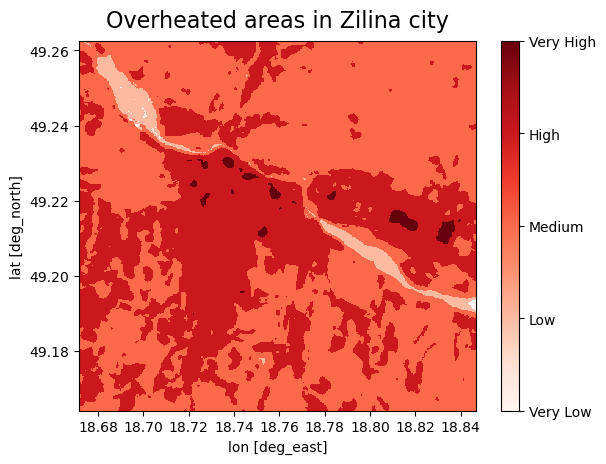

In [3]:
from rasterio.transform import from_bounds
# Load the data and calculate maximum values from raster stack
L8_path = f'{data_dir}/L8_raster_stack.tif'
L8 = xr.open_dataset(L8_path)
L8 = L8.max(dim='band', skipna=True, keep_attrs=True)
L8lst2016 = L8['band_data']
lstbbox = L8.rio.bounds()

# Function to reclassify data using numpy
def reclassify_with_numpy(array, bins, new_values):
    reclassified_array = np.zeros_like(array)
    reclassified_array[array < bins[0]] = new_values[0]
    for i in range(len(bins) - 1):
        reclassified_array[(array >= bins[i]) & (array < bins[i + 1])] = new_values[i + 1]
    reclassified_array[array >= bins[-1]] = new_values[-1]
    return reclassified_array

# Reclassify data to the groups by the temperature
lc_bins = [20, 30, 40, 50]  # Effect on the human health
lc_values = [1, 2, 3, 4, 5]

# Apply the reclassification function
lc_class = reclassify_with_numpy(L8lst2016.values, bins=lc_bins, new_values=lc_values)

# Convert the reclassified array back to xarray DataArray for plotting
lc_class_da = xr.DataArray(lc_class, coords=L8lst2016.coords, dims=L8lst2016.dims)

# Plot the data
fig, ax = plt.subplots()
oa = lc_class_da.plot(ax=ax, cmap='Reds', add_colorbar=False)
cbar = fig.colorbar(oa, ticks=[1, 2, 3, 4, 5])
cbar.ax.set_yticklabels(['Very Low', 'Low', 'Medium', 'High', 'Very High'], size=10)
ax.set_xlabel('lon [deg_east]')
ax.set_ylabel('lat [deg_north]')
plt.title('Overheated areas in Zilina city', size=16, pad=10)
plt.show()

### 5.4 Calculation of the Landsat LST from Landsat 8 - 9 imagery (only in case if you not use the RSLAB!!!)

Calculation of the Landsat LST from Landsat 8 - 9 imagery
data are from european space agency.
For the data download you need to choose the level of the data L1 or L2.
L1 level contains all 11 bands
L2 level contains bands 1-7 and band 10
We need to download the L8-9: [[Manual](https://www.youtube.com/watch?v=Eug32jeK8Gw)], [[Data](https://earth.esa.int/eogateway/catalog/landsat-8-collection-2-european-coverage)], [[Process](https://www.youtube.com/watch?v=hd7fscNTff4)]

**You do not need to calculate you can download it from [[RSLAB](https://rslab.gr/Landsat_LST.html)] for years 2013-2021**

- but if you want to most recent data (2022-Now) you need to calculate it:

In [ ]:
# Radiance
rad=0.00033420 * b10 + 0.1

# Brightest temperature
bt=1321.0789/np.log(774.8853/rad + 1)-272.15

# Normalized difference vegetation index
ndvi=(b5-b4)/(b5+b4)
ndvi_min=ndvi.min(skipna=True)
ndvi_max=ndvi.max(skipna=True)

# Proportion of the Vegetation 
pv=((ndvi +  ndvi_min)/(ndvi_max+ndvi_min))**2

# Emisivity
emi=0.004*pv+0.986

# Land surface temperature
LST=(bt+1)+10.8*(bt/14380)*np.log(emi)

In [ ]:
# Radiance
rad=0.00033420 * b10 + 0.1

In [ ]:
# Brightest temperature
bt=1321.0789/np.log(774.8853/rad + 1)-272.15

In [ ]:
# Normalized difference vegetation index
ndvi=(b5-b4)/(b5+b4)
ndvi_min=ndvi.min(skipna=True)
ndvi_max=ndvi.max(skipna=True)

In [ ]:
# Proportion of the Vegetation 
pv=((ndvi +  ndvi_min)/(ndvi_max+ndvi_min))**2

In [ ]:
# emisivity
emi=0.004*pv+0.986

In [ ]:
# land surface temperature
LST=(bt+1)+10.8*(bt/14380)*np.log(emi)

### 5.5 Plot the observed maximum 2m air temperature together with LST temperature

- We display the measured data of the 2m air temperature together with the LST data, to see for which days we downloaded the LST data.
- This step will give us the information if we downloaded the data for the days with the highest air temperature. 

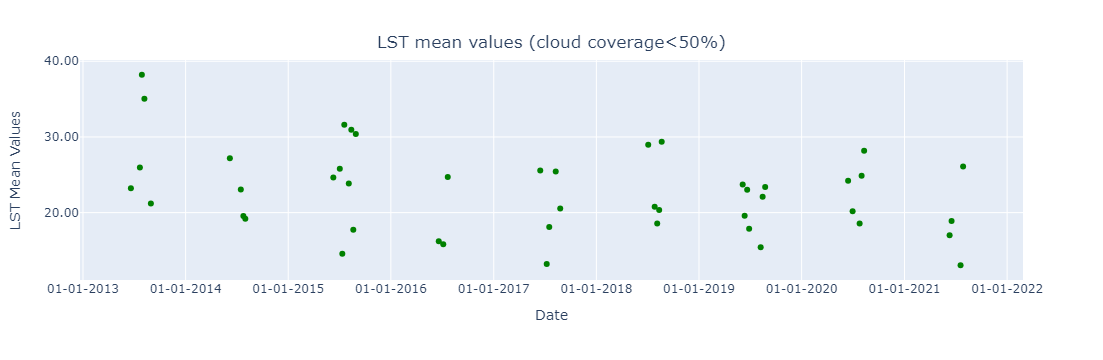

In [63]:
import datetime
# Create a dictionary from your data
data = {'Dates': lst_dates, 'Values': mean_values_list}
# Create a DataFrame from the dictionary
import pandas as pd
df = pd.DataFrame(data)
# Plot using Plotly Express
fig = px.scatter(df, x='Dates', y='Values', labels={'Dates': 'Date', 'Values': 'LST Mean Values'}, color='Values')
fig.update_traces(marker=dict(color='green'))  # Set dot color to green
fig.update_traces(mode='markers')  # Display as dots
# Add title and center it
fig.update_layout(title_text='LST mean values (cloud coverage<50%)',
                  title_x=0.5,  # Center the title horizontally
                  title_y=0.9)  # Adjust vertical position if needed
fig.update_xaxes(tickformat='%d-%m-%Y')
fig.show()

- This plot gives you the information about land surface temperature mean values for the selected area. And also gives you the information for which day you have the lst picture with cloud coverage lower then 50% of the picture

## Step 6: Identify vulnerable population groups 

- We can use the maps of the distribution of the population across the interested area and look if the most populated areas overlay with the most overheated parts. 

- For the Zilina pilot, we collected data from the Zilina municipality office about the buildings that are usually crowded with huge masses of people, e.g. hospitals, stadiums, main squares, big shopping centers, main roads, and bigger factories... **You can apply your data in this part**   

- If places like these are overheated, a huge number of people can be negatively influenced by the Heat. With that, the risk probability also rises, and thus, these areas are prioritized for Heat mitigation measures.  

### 6.1 Download the Vulnerable population data 

 1. In the link [[Source](https://data.humdata.org/dataset/?dataseries_name=Data%20for%20Good%20at%20Meta%20-%20High%20Resolution%20Population%20Density%20Maps%20and%20Demographic%20Estimates&groups=esp&res_format=GeoTIFF&q=&sort=last_modified%20desc&ext_page_size=25)]:
       -  Select the **High Resolution Population Density Maps + Demographic Estimates**
       -  Select the **Location**
       -  Select the **Formats** to GeoTIFF.
  
 2. Download the maps for the most vulnerable groups of the population **elderly 60+ years and children under 5 years**. Save the data in the data_dir where you create a folder **population** and save it there.

 3. When you download all these maps to the Heat-workflow data folder you  can use this code for data handling:
    - in the first step we load all the maps of the critical population 
    - then we calculate the sum of the vulnerable population from each of the maps
    - we classified the maps into 5 groups (equal intervals)
    - plot it next to a map of overheated areas.

### 6.2 Loads the vulnerable population data

In [7]:
# This code loads all population data and creates a raster stack from them 
poplist = glob( f'{data_dir}/population/*.tif')
#
with rasterio.open(poplist[0]) as src0:
    meta = src0.meta
#
meta.update(count = len(poplist))
#
with rasterio.open(f'{data_dir}/Population_raster_stack.tif', 'w', **meta) as dst:
    for id, layer in enumerate(poplist, start=1):
        with rasterio.open(layer) as src1:
            dst.write_band(id, src1.read(1))

### 6.3 Reclassify the vulnerable population data to 5 classes

- We need to reclassify the vulnerable population dtaa to 5 groups based on the density of the population. 

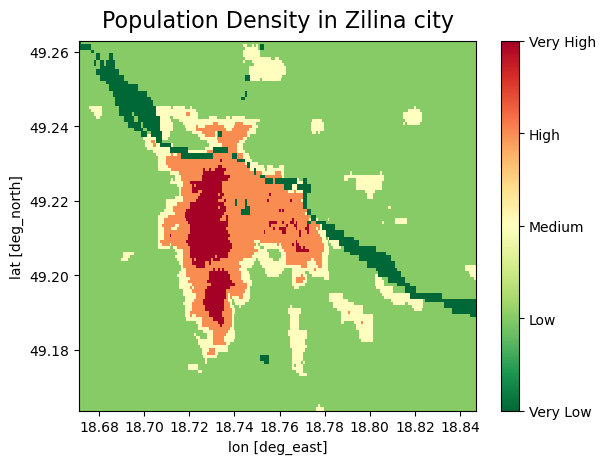

In [4]:

from rasterio.transform import from_bounds

# Load the LST data and calculate maximum values from raster stack
L8_path = f'{data_dir}/L8_raster_stack.tif'
L8 = xr.open_dataset(L8_path)
L8 = L8.max(dim='band', skipna=True, keep_attrs=True)
L8lst2016 = L8['band_data']
lstbbox = L8.rio.bounds()

# Load the population data and calculate the sum from raster stack
pop_path = f'{data_dir}/Population_raster_stack.tif'
pop = xr.open_dataset(pop_path)
pop = pop.sum(dim='band', skipna=True, keep_attrs=True)
pop = pop['band_data']
pop = pop.rio.clip_box(minx=lstbbox[0], miny=lstbbox[1], maxx=lstbbox[2], maxy=lstbbox[3])

# Function to reclassify data using numpy
def reclassify_with_numpy(array, bins, new_values):
    reclassified_array = np.zeros_like(array)
    reclassified_array[array <= bins[0]] = new_values[0]
    for i in range(len(bins) - 1):
        reclassified_array[(array > bins[i]) & (array <= bins[i + 1])] = new_values[i + 1]
    reclassified_array[array > bins[-1]] = new_values[-1]
    return reclassified_array

# Calculate the number of bins (classes)
num_bins = 4
# Equal interval classification
min_value = np.nanmin(pop)  # Minimum population value
max_value = np.nanmax(pop)  # Maximum population value
bin_width = (max_value - min_value) / num_bins  # Width of each bin
pop_bins = [min_value + i * bin_width for i in range(num_bins)]  # Define bin boundaries

# Define reclassification values
pop_values = [1, 2, 3, 4, 5]

# Apply the reclassification function to the population data
pop_class = reclassify_with_numpy(pop.values, bins=pop_bins, new_values=pop_values)

# Convert the reclassified array back to xarray DataArray for plotting
pop_class_da = xr.DataArray(pop_class, coords=pop.coords, dims=pop.dims)

# Plot the data
fig, ax = plt.subplots()
oa = pop_class_da.plot(ax=ax, cmap='RdYlGn_r', add_colorbar=False)
cbar = fig.colorbar(oa, ticks=[1, 2, 3, 4, 5])
cbar.ax.set_yticklabels(['Very Low', 'Low', 'Medium', 'High', 'Very High'], size=10)
ax.set_xlabel('lon [deg_east]')
ax.set_ylabel('lat [deg_north]')
plt.title('Population Density in Zilina city', size=16, pad=10)
plt.show()

### 6.4 Plots the maps of the overheated areas with the vulnerable groups of population 

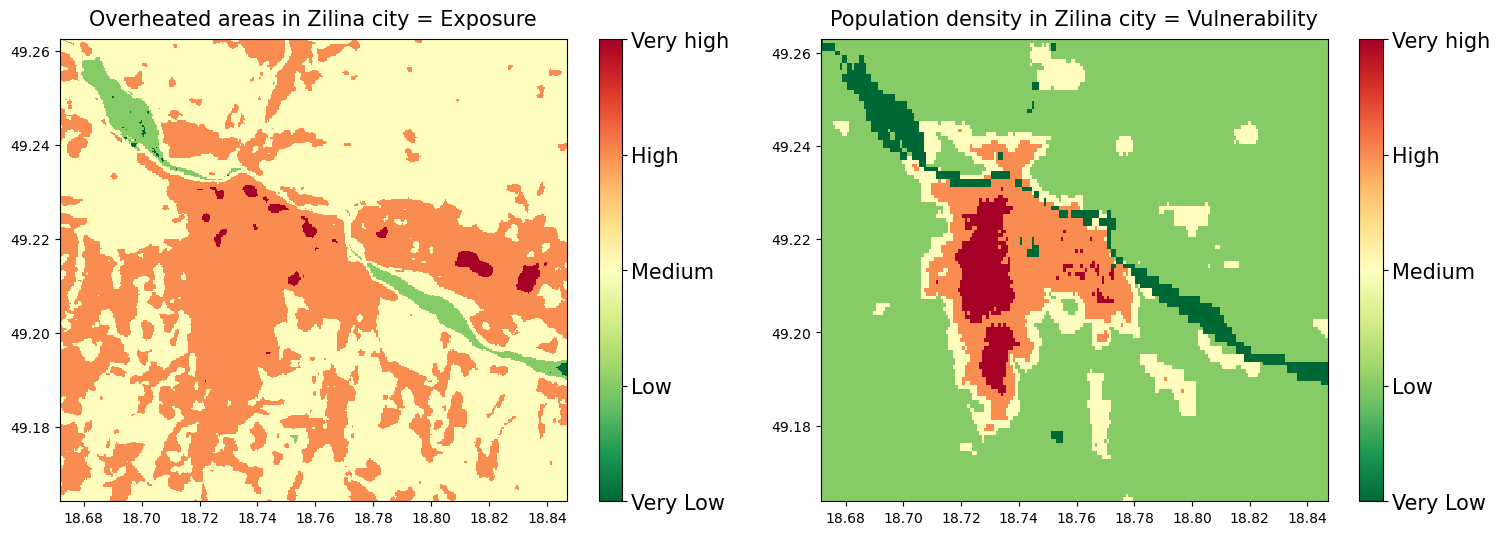

In [5]:
# This plots the Overheated areas and Population density maps
fig, axes=plt.subplots(ncols=2, figsize=(18,6))
# Plot a data
oa1 = lc_class_da.plot(ax = axes[0], cmap='RdYlGn_r', add_colorbar=False)
cbar = fig.colorbar(oa1, ticks=[ 1, 2, 3, 4, 5])
cbar.ax.set_yticklabels([ 'Very Low', 'Low', 'Medium', 'High', 'Very high'], size=15)
axes[0].set_xlabel('')
axes[0].set_ylabel('')
axes[0].set_title('Overheated areas in Zilina city = Exposure', size=15, pad = 10)
# Plot a data
oa2 = pop_class_da.plot(ax = axes[1], cmap='RdYlGn_r', add_colorbar=False)
cbar = fig.colorbar(oa2, ticks=[1, 2, 3, 4, 5])
cbar.ax.set_yticklabels([ 'Very Low', 'Low', 'Medium', 'High', 'Very high'], size=15)
axes[1].set_xlabel('')
axes[1].set_ylabel('')
axes[1].set_title('Population density in Zilina city = Vulnerability', size=15, pad = 10)
plt.draw()

- On this plots we can see the most overheated areas togehter with the population density of the vulnerable groups of population
- These maps were reclassified to the 5 groups, for the computation of the final Risk map based on the 5x5 risk matrix
- - **The Risk matrix will be used in the next step for the estimation of the risk severity**

![heatwave ilustration](https://github.com/CLIMAAX/HEATWAVES/blob/main/Images/risk_matrix.png?raw=true "Risk matrix example")

### 6.5 Save data LST and population map

In [6]:
# This code saves the data to results_dir
lc_class_da.rio.to_raster(raster_path=f'{results_dir}/risk_LST.tif')
pop_class_da.rio.to_raster(raster_path=f'{results_dir}/risk_pop.tif')

## Step 7: Calculate the heatwave risk map 

- In this step we calculate the heatwave **Risk** map based on the **Exposure (LST - most exposed areas to Heat)** x **Vulnerability (Vulnerable population)**
- **Risk = Exposure x Vulnerability**
- We need to also consider the **Probability** of the heat-occurrence under the climate scenarios. We can use the results of the heatwave hazard assessment. However, because of the coarse resolution of the hazard data, we cannot implement it directly into the Risk equation. 

### 7.1 Load a data and create a raster stack

In [7]:
# This code creates a raster stack from risk_LST and risk_pop data, we need this step for the next processing of the data 
S2list = glob( f'{results_dir}/risk_*.tif')
#
with rasterio.open(S2list[0]) as src0:
    meta = src0.meta
#
meta.update(count = len(S2list))
#
with rasterio.open(f'{results_dir}/risk_raster_stack.tif', 'w', **meta) as dst:
    for id, layer in enumerate(S2list, start=1):
        with rasterio.open(layer) as src1:
            dst.write_band(id, src1.read(1))

### 7.2 Calculate the risk 

Text(0.5, 1.0, 'Heat-wave risk level')

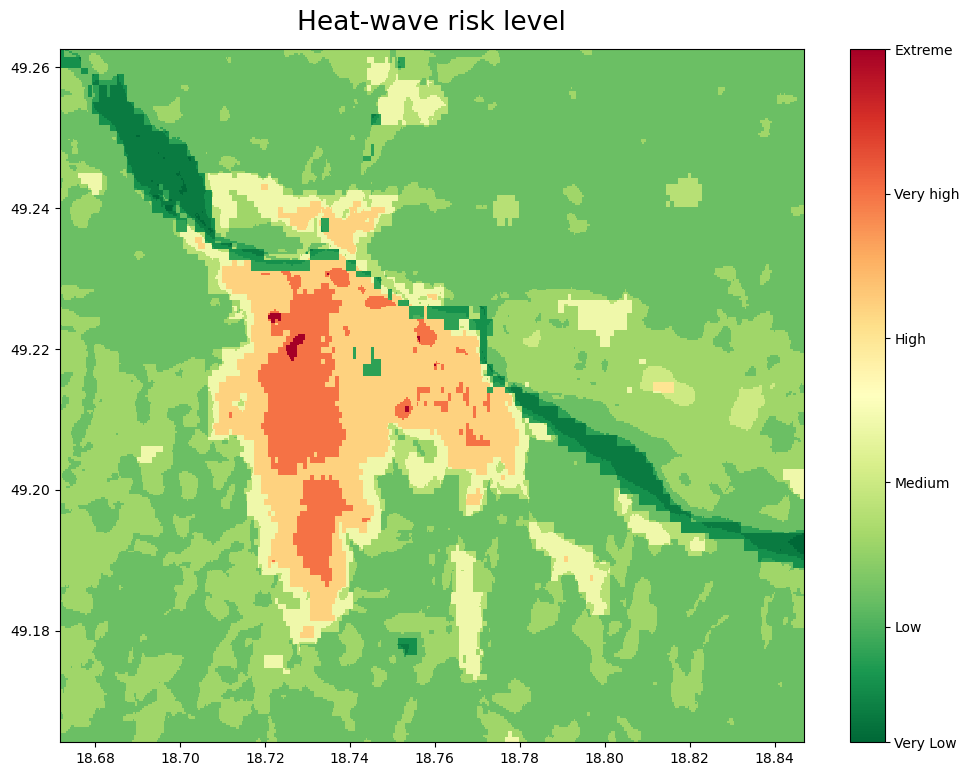

In [8]:
# This code calculates a risk map by multiplying a risk_LST and risk_pop data 
risk=f'{results_dir}/risk_raster_stack.tif'
risk = xr.open_dataset(risk)
risk=risk['band_data']
risk=(risk[0])*(risk[1])
# Plot a data
fig, ax = plt.subplots(figsize=(12, 9))

oa3 = risk.plot(ax = ax, cmap='RdYlGn_r', add_colorbar=False)
cbar = fig.colorbar(oa3, ticks=[1, 5, 10, 15, 20, 25])
cbar.ax.set_yticklabels([ 'Very Low', 'Low', 'Medium', 'High', 'Very high', 'Extreme'], size=10)
ax.set_xlabel('')
ax.set_ylabel('')
plt.title('heatwave risk level', size=19, pad = 14)

#ci= CI_WGS.plot(ax=ax, color='blue', alpha=0.3)

### 7.3 Save the risk map 

In [10]:
# This code saves the risk identification map in the results_dir
risk.rio.to_raster(raster_path=f'{results_dir}/Heatwave_risk_identificationZA.tif')

- Based on the risk interpretation map (above), we can identify the places most influenced by the heatwaves (dark red), for better visualization we can load a map with leafmap (below).

### 7.4 Plot Risk data on the interactive map

- **To see these maps on the interactive zoom in/out map with the Open Street Base map run the code bellow**

In [17]:
# This code creates a tile client from risk maps
# First, create a tile server from local raster file
riskpop = TileClient(f'{results_dir}/risk_pop.tif')
riskLST = TileClient(f'{results_dir}/risk_LST.tif')
HWRI = TileClient(f'{results_dir}/Heatwave_risk_identificationZA.tif')

In [18]:
# This code creates ipyleaflet tile layer from that server
tpop = get_leaflet_tile_layer(riskpop, cmap='Reds',opacity=0.7, nodata=0, name='Risk population')
tLST = get_leaflet_tile_layer(riskLST, cmap='bwr',opacity=0.7, nodata=0, name='LST')
tHWRI = get_leaflet_tile_layer(HWRI, cmap='RdYlGn_r',opacity=0.7, nodata=0, name='Heat wave risk identification')

In [19]:
# This code plots the results on the ipyleaflet map 
from ipyleaflet import Map, LayersControl, WidgetControl
import ipywidgets as widgets

# Set the size of the map
map_layout = widgets.Layout(width='1100px', height='800px')

# This code plots all loaded rasters and vectors on the ipyleaflet map
m = Map(center=riskLST.center(), zoom=riskLST.default_zoom, layout=map_layout)

control = LayersControl(position='topright')

m.add(tpop)
m.add(tLST)
m.add(tHWRI)

labels = ["Very low", "Low", "Medium", "Very high", "Extreme"]
colors = [(0, 104, 55), (35, 132, 67), (255, 255, 191), (255, 127, 0), (215, 25, 28)]

# Create legend HTML content with custom styles (smaller size)
legend_html = "<div style='position: absolute; bottom: 2px; left: 2px; padding: 10px; " \
              "background-color: #FFF; border-radius: 10px; box-shadow: 2px 2px 2px rgba(0,0,0,0.5); " \
              "width: 75px; height: 205px; '>"

# Append legend items (labels with colored markers)
for label, color in zip(labels, colors):
    color_hex = '#%02x%02x%02x' % color  # Convert RGB tuple to hex color
    legend_html += f"<p style='font-family: Arial, sans-serif; font-size: 14px; '>" \
                   f"<i style='background: {color_hex}; width: 10px; height: 10px; display: inline-block;'></i> {label}</p>"

legend_html += "</div>"

# Create a custom widget with the legend HTML
legend_widget = widgets.HTML(value=legend_html)

legend_control = WidgetControl(widget=legend_widget, position='bottomleft')
m.add_control(legend_control)

m.add(control)
m.add(geo_json1)

m

Map(center=[49.2133495, 18.759248499999998], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_…

- You can add or remove a map by "click" on the "layer control" in the top right corner, or "Zoom in/out" by "click" on the [+]/[-] in the top left corner 
- **We recommend first unclicking all the maps and then displaying them one by one, the transparency of the maps allows you to see which areas on the OpenStreetMap are most exposed to the heat, and in combination with the distribution of the vulnerable population, you can easily identify which areas should be prioritized for the application of the heat mitigation measures.** 

## Step 8: Conslusion for the Risk identification results

- The results of the Risk workflow help you identify the places that are the most exposed to the effect of heat and also places populated with the vulnerable groups of populations in terms of heat.
- Together with the results of the Hazard assessment workflow that gives you the information about the **probability of the heatwave occurrence** in the future, gives you a picture of the heatwave-connected problems in your selected area.

![Heat-wave ilustration](https://github.com/CLIMAAX/HEATWAVES/blob/main/Images/hw_year_pesetaiv.png?raw=true "Risk matrix example")

  
- However, we need to also consider the **limitations of the data used for this analysis**:
  - The Land surface temperature data derived from the Landsat 8 satellite imagery, do not provide data in daily steps. That means we get limited information on the maximum LST (because there is a possibility of the hotter days without an LST image from Landsat8). The resolution of the 30x30m also has a limitation, especially in the densely built-up areas.
  - The world population data were prepared for the year 2020, and there can be a change to the current day.
  - For this workflow, it will be best to prepare your vulnerable population (places) data with your local authorities.
 


## References

- Climate adapt, Apparent temperature heatwave days (2021), https://climate-adapt.eea.europa.eu/en/metadata/indicators/apparent-temperature-heatwave-days [2024-06-17].

- Climate adapt, Tropical nights (2021), https://climate-adapt.eea.europa.eu/en/observatory/++aq++metadata/indicators/tropical-nights/ [2024-06-17].

- Climate adapt, High UTCI Days (2021), https://climate-adapt.eea.europa.eu/en/metadata/indicators/high-utci-days [2024-06-17].

- humdata.org, High Resolution Population Density Maps + Demographic Estimates (2020), https://data.humdata.org/dataset/albania-high-resolution-population-density-maps-demographic-estimates [2024-06-20]

- European Space Agency ESA, Landsat 8 satellite imagery (2013), https://earth.esa.int/eogateway/catalog/landsat-8-collection-2-european-coverage [2024-06-20]

- Utah Space University, Difference between Air and surface temperature (2024), https://caas.usu.edu/weather/graphical-data/surface-temperature [2024-06-20]

- United States Environmental Protection Agency EPA, Heat Island Effect (2024), https://www.epa.gov/heatislands [2024-06-20]

- Nazarian, N., Krayenhoff, E. S., Bechtel, B., Hondula, D. M., Paolini, R., Vanos, J., Cheung, T., Chow, W. T. L., de Dear, R., Jay, O., Lee, J. K. W., Martilli, A., Middel, A., Norford, L. K., Sadeghi, M., Schiavon, S., Santamouris, M. (2022), Integrated Assessment of Urban Overheating Impacts on Human Life, Earth’s Future, 10(9). https://doi.org/10.1029/2022EF002682

- Parastatidis D, Mitraka Z, Chrysoulakis N, Abrams M. Online Global Land Surface Temperature Estimation from Landsat. Remote Sensing. (2017); 9(12):1208. https://doi.org/10.3390/rs9121208

- RSLAB, Land surface temperature, based on the Landsat8 imagery, https://rslab.gr/Landsat_LST.html [2024-06-20]

## Authors 

- Martin Kuban, KAJO services (martin.kuban@kajoservices.com)
- Milan Kalas, KAJO services (milan.kalas@kajoservices.com)